# Vision Transformer / ViT

In [19]:
 # For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    

[INFO] torch/torchvision versions not as required, installing nightly versions.


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [20]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


In [21]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 


'cpu'

### Get data 

In [22]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [23]:
# Setup directory paths to train and test images
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [24]:
## Create Transforms
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size 
IMG_SIZE = 224  # comes from Tables 3 of the ViT paper

# Create transforms pipeline 
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()     
])

print(f'Manually created transforms: {manual_transforms}')


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [25]:
# Create a batch size (32, the paper uses 4096)
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  
    batch_size=BATCH_SIZE
)
len(train_dataloader), len(test_dataloader), class_names


(8, 3, ['pizza', 'steak', 'sushi'])

In [26]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label


(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

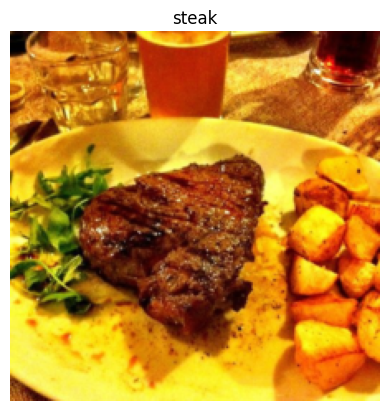

In [27]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

### Split data into patches and creating the class, position and patch embedding

In [28]:
# Create example values 
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches N
number_of_patches = int((height * width) / patch_size**2)
number_of_patches
 

196

In [29]:
# Input shape 
embedding_layer_input_shape = (height, width, color_channels)

# Output shape 
embedding_layer_output_shape = (number_of_patches, patch_size**2 \
    * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D image): {embedding_layer_output_shape}')


Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D image): (196, 768)


### Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

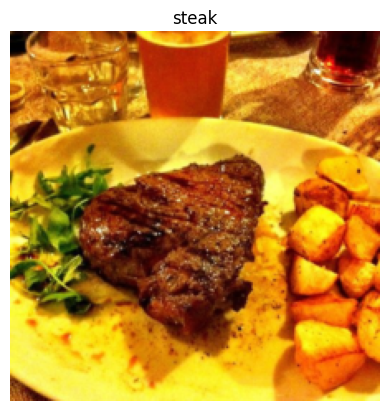

In [30]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)


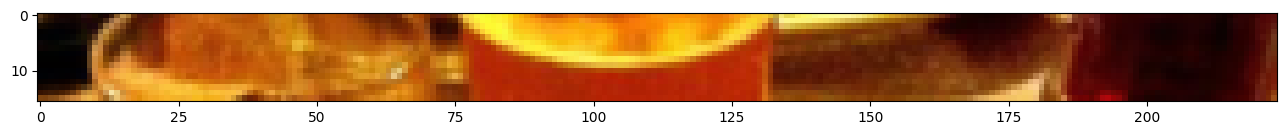

In [31]:
# Get the top row of pixels
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


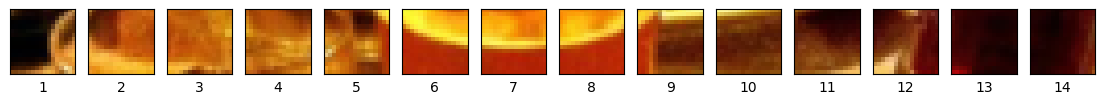

In [32]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


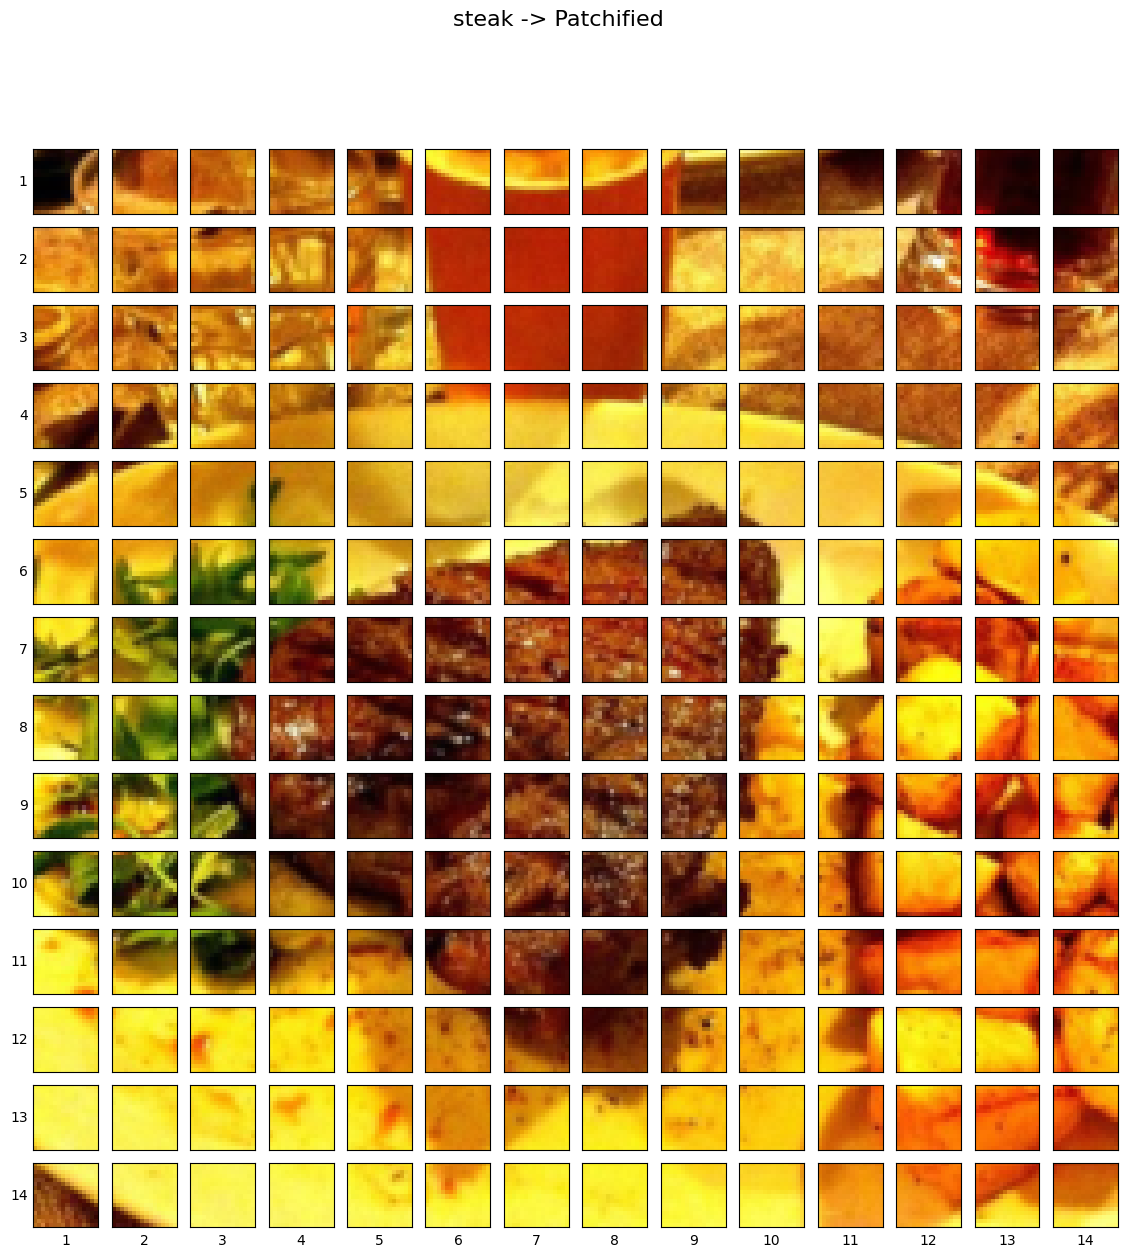

In [33]:
# Setup code to plot whole image as patches 
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()



In [34]:
# Create conv2d layer to turn image into patches / embeddings
from torch import nn

# Set the patch size 
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper 
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,  # 16*16*3
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d                   

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

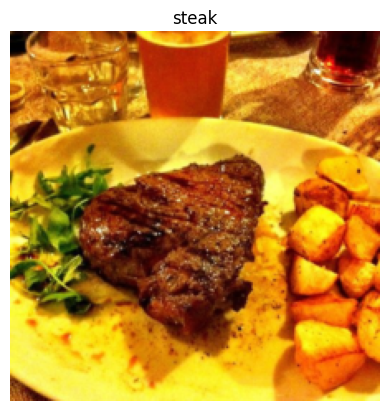

In [35]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [36]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)


torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [701, 532, 647, 539, 692]


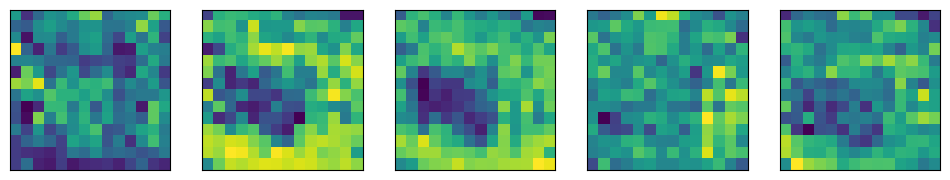

In [37]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);
    

In [38]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad


(tensor([[[ 0.0993,  0.3668,  0.4264,  0.3595,  0.3618,  0.0551,  0.1230,
            0.1374,  0.1444,  0.0336,  0.0931,  0.3887,  0.1495,  0.0521],
          [ 0.3445,  0.3023,  0.2153,  0.2953,  0.3649,  0.2500,  0.2646,
            0.2655,  0.5011,  0.2814,  0.2186,  0.1593,  0.1665,  0.2388],
          [ 0.1932,  0.2355,  0.3616,  0.5321,  0.3376,  0.2446,  0.2867,
            0.2815,  0.2360,  0.2832,  0.2247,  0.2944,  0.2074,  0.4439],
          [ 0.2762,  0.0480,  0.3568,  0.3000,  0.4607,  0.5048,  0.5757,
            0.6197,  0.4619,  0.4449,  0.4458,  0.3516,  0.4542,  0.0470],
          [ 0.3406,  0.2974,  0.3502,  0.3832,  0.3566,  0.3115,  0.3666,
            0.2502,  0.1382,  0.1333,  0.3342,  0.1761,  0.3954,  0.4464],
          [ 0.4811,  0.3683,  0.1903,  0.2912,  0.1975,  0.0880,  0.1217,
            0.1280,  0.1569,  0.1765,  0.3574,  0.2596,  0.2059,  0.4167],
          [ 0.1466,  0.0741,  0.1173, -0.0143,  0.1149,  0.0542,  0.1890,
            0.4017,  0.2552, -0.

### Flattening the patch embedding

In [39]:
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [40]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,  # torch.Size([1, 768, 14, 14]) flatten 14, 14
                           end_dim=3)

flatten_layer(image_out_of_conv).shape


torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


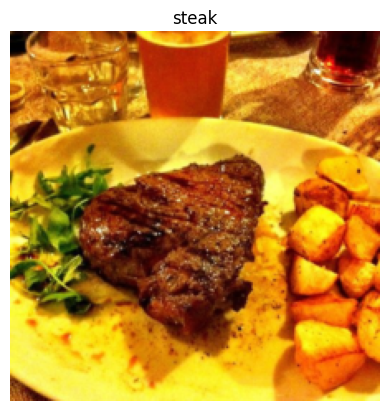

In [41]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [42]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) 

print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")


Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


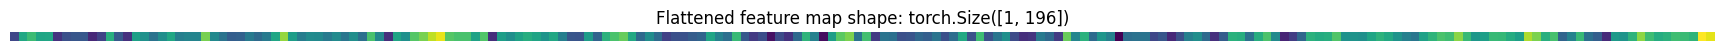

In [43]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);


In [44]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape


(tensor([[ 0.0993,  0.3668,  0.4264,  0.3595,  0.3618,  0.0551,  0.1230,  0.1374,
           0.1444,  0.0336,  0.0931,  0.3887,  0.1495,  0.0521,  0.3445,  0.3023,
           0.2153,  0.2953,  0.3649,  0.2500,  0.2646,  0.2655,  0.5011,  0.2814,
           0.2186,  0.1593,  0.1665,  0.2388,  0.1932,  0.2355,  0.3616,  0.5321,
           0.3376,  0.2446,  0.2867,  0.2815,  0.2360,  0.2832,  0.2247,  0.2944,
           0.2074,  0.4439,  0.2762,  0.0480,  0.3568,  0.3000,  0.4607,  0.5048,
           0.5757,  0.6197,  0.4619,  0.4449,  0.4458,  0.3516,  0.4542,  0.0470,
           0.3406,  0.2974,  0.3502,  0.3832,  0.3566,  0.3115,  0.3666,  0.2502,
           0.1382,  0.1333,  0.3342,  0.1761,  0.3954,  0.4464,  0.4811,  0.3683,
           0.1903,  0.2912,  0.1975,  0.0880,  0.1217,  0.1280,  0.1569,  0.1765,
           0.3574,  0.2596,  0.2059,  0.4167,  0.1466,  0.0741,  0.1173, -0.0143,
           0.1149,  0.0542,  0.1890,  0.4017,  0.2552, -0.0226,  0.3358,  0.4697,
           0.506

## Turning the ViT patch embedding layer into a PyTorch module

In [45]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
    
    

In [46]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [47]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [48]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[-0.4473,  0.0253, -0.0367,  ...,  0.3751, -0.1847, -0.2120],
         [-0.5062, -0.0335, -0.1157,  ...,  0.3123, -0.2404,  0.2829],
         [-0.5490,  0.0876, -0.0934,  ...,  0.3331, -0.3080,  0.2185],
         ...,
         [-0.6589,  0.0723, -0.1464,  ...,  0.3418, -0.2853,  0.3043],
         [-0.5103,  0.0736, -0.2465,  ...,  0.4819, -0.2938,  0.2822],
         [-0.6187,  0.1460, -0.3046,  ...,  0.4252, -0.2534,  0.3265]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [49]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [50]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4473,  0.0253, -0.0367,  ...,  0.3751, -0.1847, -0.2120],
         [-0.5062, -0.0335, -0.1157,  ...,  0.3123, -0.2404,  0.2829],
         ...,
         [-0.6589,  0.0723, -0.1464,  ...,  0.3418, -0.2853,  0.3043],
         [-0.5103,  0.0736, -0.2465,  ...,  0.4819, -0.2938,  0.2822],
         [-0.6187,  0.1460, -0.3046,  ...,  0.4252, -0.2534,  0.3265]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### Creating the position embedding

In [51]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4473,  0.0253, -0.0367,  ...,  0.3751, -0.1847, -0.2120],
          [-0.5062, -0.0335, -0.1157,  ...,  0.3123, -0.2404,  0.2829],
          ...,
          [-0.6589,  0.0723, -0.1464,  ...,  0.3418, -0.2853,  0.3043],
          [-0.5103,  0.0736, -0.2465,  ...,  0.4819, -0.2938,  0.2822],
          [-0.6187,  0.1460, -0.3046,  ...,  0.4252, -0.2534,  0.3265]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [52]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Putting it all together: from image to embedding

In [53]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## MSA Block

In [54]:
class MultiheadSelfAttentionBlock(nn.Module):
    '''Creates a multi-head self-attention block'''
    def __init__(
        self, 
        embedding_dim:int=768,
        num_heads:int=12,
        attn_dropout:int=0):
        
        super().__init__()
        
        # Create the norm layer 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create multihead attention layer 
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout, 
                                                    batch_first=True)  # (batch, seq, feature) -> (batch, num_patches, embedding_dimension)     
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x, 
            key=x, 
            value=x, 
            need_weights=False)
        return attn_output

In [55]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim=768, num_heads=12) 
# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## MLP Block

In [56]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072,
                dropout:int=0.1):
        super().__init__()
        
        # Create the norm layer 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Create the MLP 
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
    

In [57]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

## Transformer Encoder 

In [58]:
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        embedding_dim:int=768,
        num_heads:int=12,
        mlp_size:int=3072, 
        mlp_dropout:int=0.1,
        attn_dropout:int=0):
        super().__init__()
        
        # MSA block 
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads, 
            attn_dropout=attn_dropout)
        
        # MLP block
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size, 
            dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x  # residual connection 
        x = self.mlp_block(x) + x
        return x
    
    

In [59]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Summary / torchinfo.summary
summary(model=transformer_encoder_block, 
        input_size=(1, 197, 768),  # batch_size, number_of_patches, embedding_dimension
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, 
        row_settings=['var_names'])



Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Create a Transformer Encoder layer with PyTorch layers 

In [60]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072, 
    dropout=0.1, 
    activation='gelu',
    batch_first=True,
    norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [61]:
# Summary / torchinfo.summary
summary(model=torch_transformer_encoder_layer, 
        input_size=(1, 197, 768),  # batch_size, number_of_patches, embedding_dimension
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## Create ViT

In [62]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    '''Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.'''
    
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000): 
        super().__init__() 
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f'Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}.'
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim),
            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches+1, embedding_dim),
            requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks 
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,                                      num_heads=num_heads,                                                   mlp_size=mlp_size,                                                     mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes))
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1) 

        # 14. Create patch embedding 
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding  
        x = self.position_embedding + x

        # 17. Run embedding dropout
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [63]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(
    data=torch.randn(1, 1, embedding_dim),
    requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)


torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [64]:
vit = ViT()
vit 


ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

### Setting up training code

In [65]:
# Creating an optimizer 
optimizer = torch.optim.Adam(
    vit.parameters(), 
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=0.1)

# Loss function 
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=5, 
    optimizer=optimizer, 
    loss_fn=loss_fn,
    device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

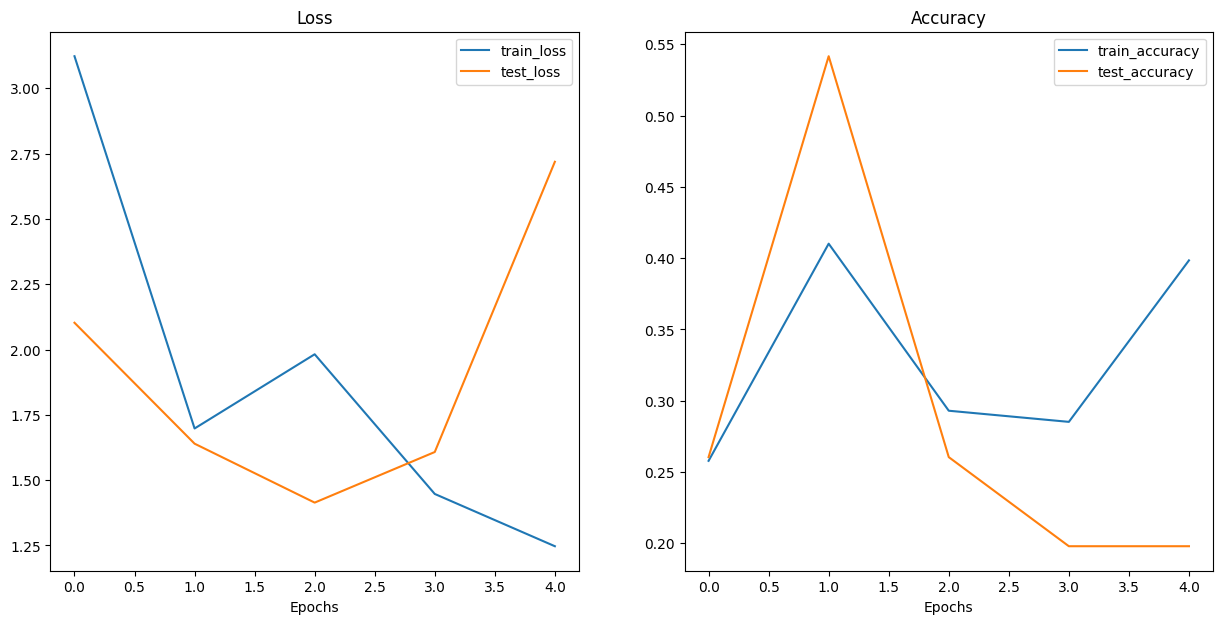

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)


The model is underfitting and overfitting 

# pretrained ViT / torch.models

In [68]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights 
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device=device)

# Freeze the base parameters 
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)



In [69]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, 
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Preparing data for ViT


In [70]:
# Get automatic transforms for ViT
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [71]:
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [72]:
# Setup dataloaders 
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir= test_dir,
    transform=vit_transforms,
    batch_size=32)


### Train ViT

In [76]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier 
set_seeds()
results = pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained, 
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1101 | train_acc: 0.9766 | test_loss: 0.2169 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.0757 | train_acc: 0.9922 | test_loss: 0.1995 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.0578 | train_acc: 0.9922 | test_loss: 0.2054 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.0438 | train_acc: 0.9922 | test_loss: 0.2026 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.0338 | train_acc: 0.9961 | test_loss: 0.1951 | test_acc: 0.9280


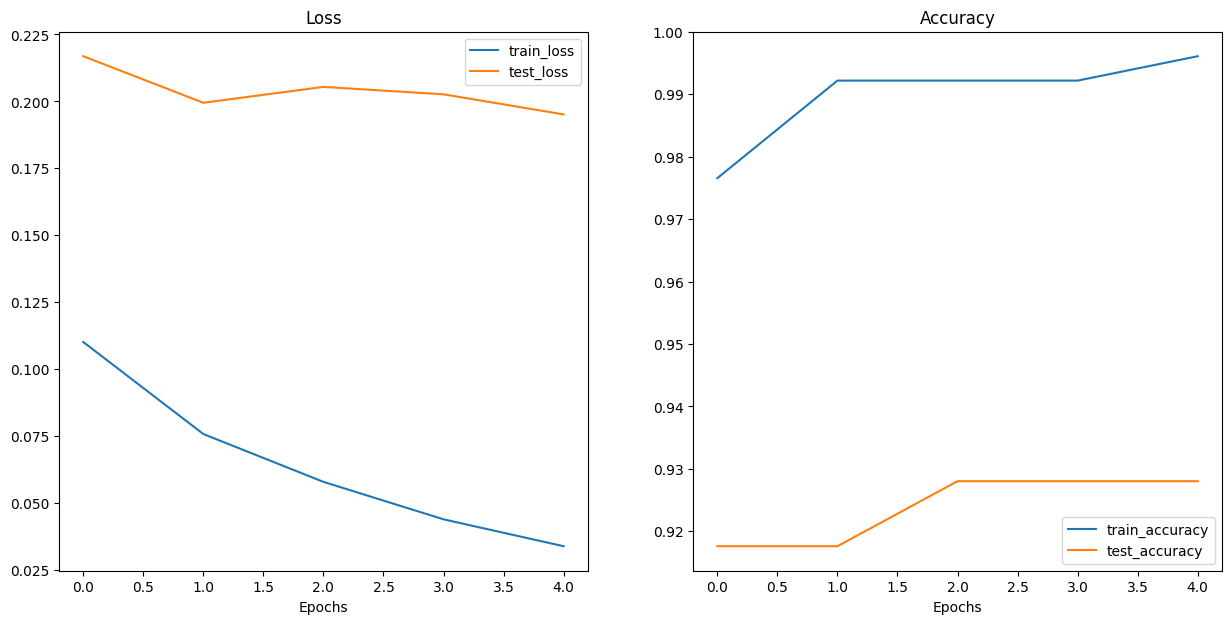

In [77]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)


### Save the model

In [79]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir='models',
                 model_name='pretrained_vit.pth')

[INFO] Saving model to: models/pretrained_vit.pth


In [82]:
from pathlib import Path

#Get the model size
model_size = Path('models/pretrained_vit.pth').stat().st_size // (1021*1024)
print(f'Model size {model_size} MB')


Model size 328 MB
